In [1]:
#import needed libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tensorflow import keras
from keras.models import load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.preprocessing import image
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.applications.resnet_v2 import ResNet152V2
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix

import os

ModuleNotFoundError: No module named 'tensorflow.python.keras.applications'

**To split into train test and validate folders I am going to use this library**

In [2]:
pip install split-folders --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import splitfolders
splitfolders.ratio("../input/flowers-recognition/flowers",output="Tr-Te-Val",ratio=(0.8,0.1,0.1))

Copying files: 4326 files [00:20, 212.60 files/s]


In [4]:
os.removedirs("./Tr-Te-Val/train/flowers")
os.removedirs("./Tr-Te-Val/test/flowers")
os.removedirs("./Tr-Te-Val/val/flowers")

**Image data from the folders using Image Data Generator**

In [5]:
train_gen = Imgen(preprocessing_function=keras.applications.resnet_v2.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                 )

val_gen = Imgen(preprocessing_function=keras.applications.resnet_v2.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                 )

test_gen = Imgen(preprocessing_function=keras.applications.resnet_v2.preprocess_input
                 )

In [6]:
train_ds = train_gen.flow_from_directory("./Tr-Te-Val/train",
                                       target_size=(224,224),
                                        seed = 123,
                                        batch_size=32
                                       )

val_ds = val_gen.flow_from_directory("./Tr-Te-Val/val",
                                       target_size=(224,224),
                                        seed = 123,
                                        batch_size=32)

test_ds = test_gen.flow_from_directory("./Tr-Te-Val/test",
                                       target_size=(224,224),
                                        seed = 123,
                                        batch_size=32,
                                      shuffle=False
                                      )

Found 3457 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 436 images belonging to 5 classes.


**Getting the name of classes for ease of use**

In [7]:
a = train_ds.class_indices
classes = list(a.keys())
print(classes)
b = test_ds.class_indices
classes = list(b.keys())
print(classes)
c = val_ds.class_indices
classes = list(c.keys())
print(classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


**Extracting one batch from datagen for visualization purposes**

In [8]:
#one batch
X,Y = next(train_ds)
#print(X,Y)

In [9]:
#plot function
def plot_images(img,labels):
    plt.figure(figsize=(15,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(img[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')

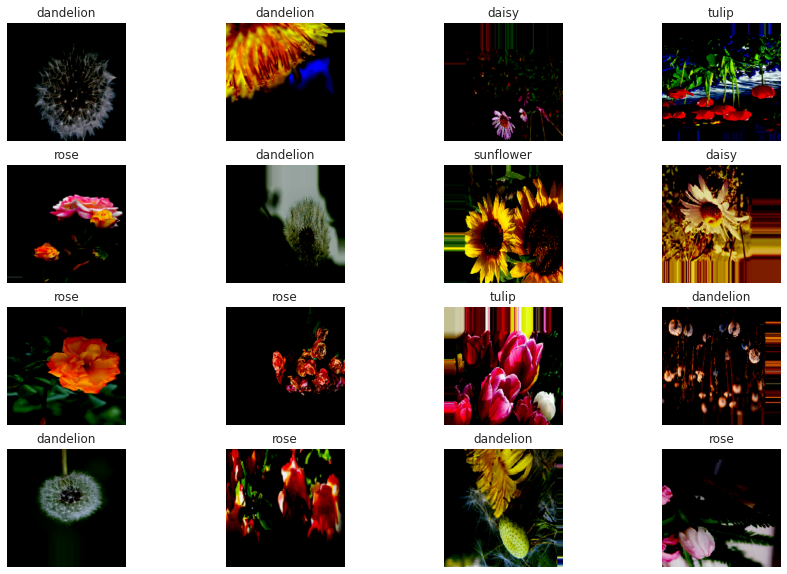

In [10]:
plot_images(X,Y)

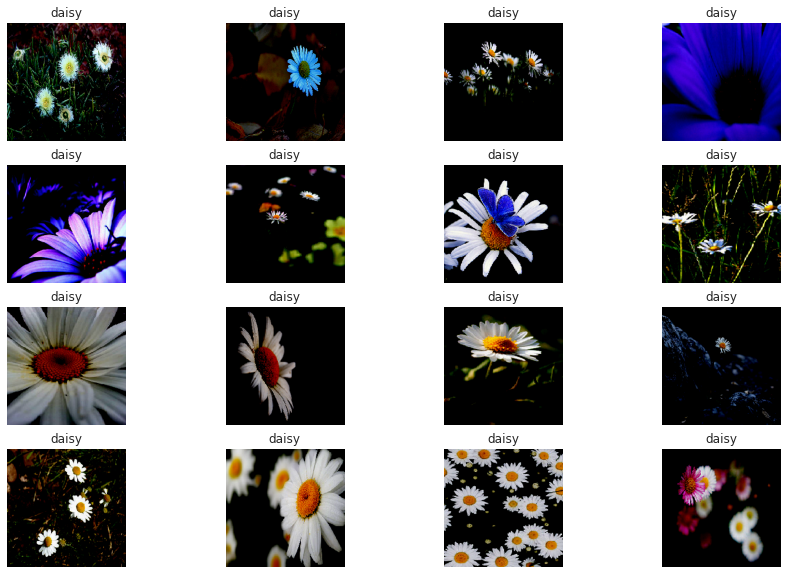

In [11]:
u,v=next(test_ds)
plot_images(u,v)

## **Using Transfer Learning to build the Model**

In [12]:
#from keras.applications.densenet import DenseNet201
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.applications.resnet_v2 import ResNet152V2

In [13]:
base_model = ResNet152V2(include_top=False,
                  input_shape=(224,224,3),
                   weights = 'imagenet',
                    pooling='avg'
                  )
base_model.trainable = False

234553344/234545216 [==============================] - 2s 0us/step


In [14]:
inputs = base_model.input
l1 = Dense(128,activation='relu')(base_model.output)
outputs = Dense(5,activation='softmax')(l1)
model = keras.Model(inputs=inputs,outputs=outputs)

In [15]:
#compile 
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**Defining callbacks to get the best model possible**

In [16]:
#callbacks
my_calls = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
            keras.callbacks.ModelCheckpoint("Model.h5",verbose=1,save_best_only=True)]

**Training**

In [17]:
hist = model.fit(train_ds,epochs=18,validation_data=val_ds,callbacks=my_calls)

Epoch 1/18
109/109 [==============================] - 66s 496ms/step - loss: 0.8392 - accuracy: 0.6746 - val_loss: 0.6201 - val_accuracy: 0.8000

Epoch 00001: val_loss improved from inf to 0.62013, saving model to Model.h5
Epoch 2/18
109/109 [==============================] - 51s 465ms/step - loss: 0.4797 - accuracy: 0.8333 - val_loss: 0.4143 - val_accuracy: 0.8372

Epoch 00002: val_loss improved from 0.62013 to 0.41427, saving model to Model.h5
Epoch 3/18
109/109 [==============================] - 51s 469ms/step - loss: 0.3475 - accuracy: 0.8738 - val_loss: 0.4265 - val_accuracy: 0.8465

Epoch 00003: val_loss did not improve from 0.41427
Epoch 4/18
109/109 [==============================] - 51s 466ms/step - loss: 0.3105 - accuracy: 0.8894 - val_loss: 0.4378 - val_accuracy: 0.8535

Epoch 00004: val_loss did not improve from 0.41427
Epoch 5/18
109/109 [==============================] - 51s 468ms/step - loss: 0.2930 - accuracy: 0.8876 - val_loss: 0.3985 - val_accuracy: 0.8442

Epoch 0000

**Getting the saved model**

In [18]:
model = load_model("./Model.h5")

In [19]:
#test
model.evaluate(test_ds)

14/14 [==============================] - 4s 148ms/step - loss: 0.3179 - accuracy: 0.8784


[0.31788697838783264, 0.8784403800964355]

**Graphs to show loss and accuracy along the training**

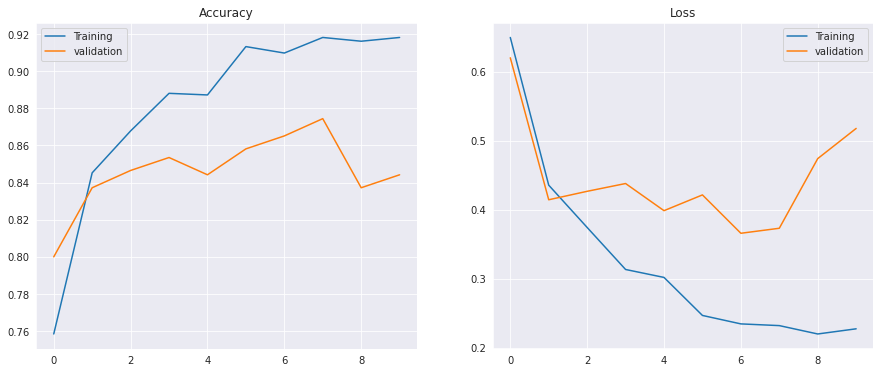

In [20]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Making Predictions and Verifying**

In [21]:
preds = model.predict(test_ds,verbose=1)

14/14 [==============================] - 4s 162ms/step


In [22]:
pred = [np.argmax(i) for i in preds]
pred[:5]

[0, 0, 0, 0, 0]

In [23]:
actual = test_ds.classes

**Classification Report**

In [24]:
print(classification_report(pred,actual))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.91      0.90      0.90       107
           2       0.89      0.86      0.87        81
           3       0.86      0.85      0.86        75
           4       0.83      0.90      0.86        91

    accuracy                           0.88       436
   macro avg       0.88      0.88      0.88       436
weighted avg       0.88      0.88      0.88       436



**Confusion Matrix**

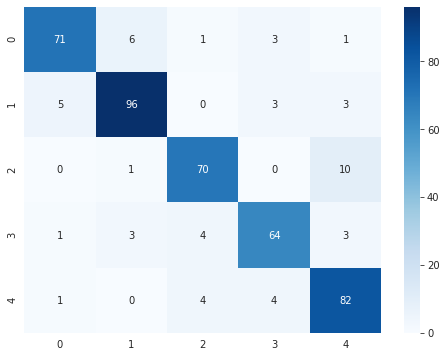

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred,actual),annot = True, fmt = 'd', cmap = 'Blues');

**Individual image Identification**

> function to predict

In [26]:
def predict_img(path):
    img = image.load_img(path,target_size=(224,224))
    img_arr = image.img_to_array(img)
    img_arr_expnd  = np.expand_dims(img_arr,axis=0)
    img = keras.applications.resnet_v2.preprocess_input(img_arr_expnd)
    
    pred = model.predict(img)
    result = classes[np.argmax(pred)]
    
    return result

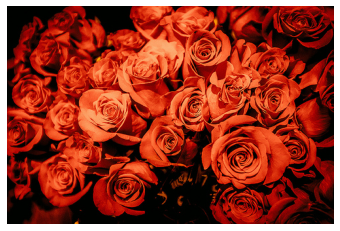

In [27]:
plt.imshow(Image.open("../input/flowers-recognition/flowers/rose/10503217854_e66a804309.jpg"))
plt.axis('off');

**Prediction**

In [28]:
print("The given image belongs to class:",predict_img("../input/flowers-recognition/flowers/rose/10503217854_e66a804309.jpg"))

The given image belongs to class: rose
